In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from fee_algorithm.fee_based_on_trade import FeeBasedOnTrade
from fee_algorithm.fixed_fee import FixedFee
from prices_snapshot import PricesSnapshot
from visualizations.utility import get_initial_pool_sizes
from pool.liquidity_state import PoolLiquidityState


In [3]:
prices = PricesSnapshot(
    price_a=69989, # ETH
    price_b=2518, # BTC
)

initial_quantity_a, initial_quantity_b = get_initial_pool_sizes(prices.price_a, prices.price_b, total_pool=10000)

print(f"Initial fair pool sizes: {initial_quantity_a}, {initial_quantity_b}")

initial_pool_state = PoolLiquidityState(
    quantity_a=initial_quantity_a - 100,
    quantity_b=initial_quantity_b,
)

print(f"Initial pool state: {initial_pool_state}")

Initial fair pool sizes: 347.2768146523784, 9652.723185347622
Initial pool state: PoolLiquidityState(quantity_a=247.2768146523784, quantity_b=9652.723185347622)


In [4]:
print(f"A -> B price according to the pool: {initial_pool_state.get_a_to_b_exchange_price()}")
print(f"Fair A -> B price: {prices.get_a_to_b_price()}")

A -> B price according to the pool: 39.0361029153397
Fair A -> B price: 27.795472597299444


In [5]:
fixed_fee = FixedFee(0.003)
fee_based_on_trade = FeeBasedOnTrade(0.003)

fee_based_on_trade.process_oracle_price(prices.get_a_to_b_price())

In [6]:
import numpy as np

res = []

for x_user in np.linspace(0, 200, 100):
    fixed_fee_paid = fixed_fee.get_a_to_b_exchange_fee_rate(initial_pool_state) * x_user
    fee_based_on_trade_paid = fee_based_on_trade.get_a_to_b_trade_fee(initial_pool_state, x_user)

    print(f"User exchanged {x_user} A for B")
    print(f"Fixed fee paid: {fixed_fee_paid}")
    print(f"Fee based on trade paid: {fee_based_on_trade_paid}")

    res.append(
        {
            "x_user": x_user,
            "fixed_fee_paid": fixed_fee_paid,
            "fee_based_on_trade_paid": fee_based_on_trade_paid,
        }
    )

User exchanged 0.0 A for B
Fixed fee paid: 0.0
Fee based on trade paid: 0.0
User exchanged 2.0202020202020203 A for B
Fixed fee paid: 0.0060606060606060615
Fee based on trade paid: 0.008407718904079875
User exchanged 4.040404040404041 A for B
Fixed fee paid: 0.012121212121212123
Fee based on trade paid: 0.016681368144420006
User exchanged 6.0606060606060606 A for B
Fixed fee paid: 0.01818181818181818
Fee based on trade paid: 0.024824116396305662
User exchanged 8.080808080808081 A for B
Fixed fee paid: 0.024242424242424246
Fee based on trade paid: 0.032839033656888006
User exchanged 10.101010101010102 A for B
Fixed fee paid: 0.030303030303030307
Fee based on trade paid: 0.04072909504154332
User exchanged 12.121212121212121 A for B
Fixed fee paid: 0.03636363636363636
Fee based on trade paid: 0.048497184407093386
User exchanged 14.141414141414142 A for B
Fixed fee paid: 0.04242424242424243
Fee based on trade paid: 0.056146097810943374
User exchanged 16.161616161616163 A for B
Fixed fee pa

In [7]:
from user.informed_user import InformedUser
from pool.pool import Pool

fixed_fee_pool = Pool(
    liquidity_state=initial_pool_state,
    fee_algorithm=fixed_fee,
)

optimal_action_with_fixed_fee = InformedUser().get_user_action(pool=fixed_fee_pool, network_fee=0, prices=prices)

print(f"Optimal action with fixed fee: {optimal_action_with_fixed_fee}")

Optimal action with fixed fee: UserAction(delta_x=np.float64(-45.46149055165133), delta_y=np.float64(1495.2420723747955), fee_x=np.float64(0.136384471654954), fee_y=0)


In [8]:
from user.informed_user_bruteforce import InformedUserBruteforce

fee_based_on_trade_pool = Pool(
    liquidity_state=initial_pool_state,
    fee_algorithm=fee_based_on_trade,
)

optimal_action_with_fee_based_on_trade = InformedUserBruteforce().get_user_action(pool=fee_based_on_trade_pool, network_fee=0, prices=prices)

print(f"Optimal action with fee based on trade: {optimal_action_with_fee_based_on_trade}")

Optimal action with fee based on trade: UserAction(delta_x=np.float64(-44.554381018446556), delta_y=np.float64(1469.2513800746983), fee_x=np.float64(0.15857813263632892), fee_y=0)


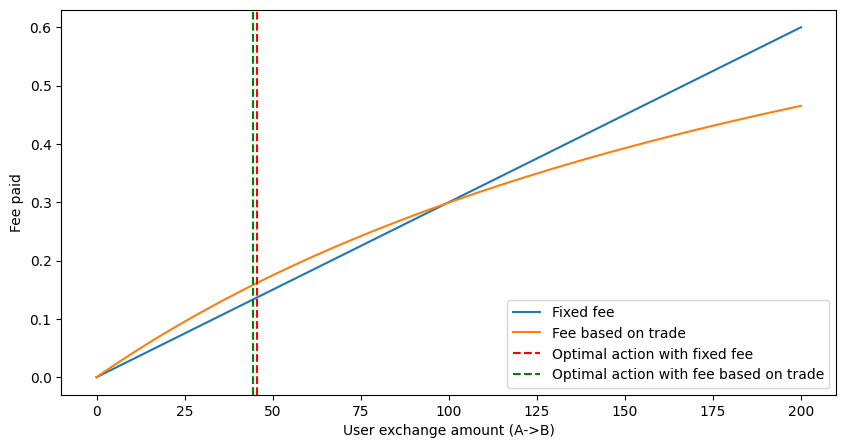

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res_pd = pd.DataFrame(res)

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=res_pd, x="x_user", y="fixed_fee_paid", label="Fixed fee", ax=ax)
sns.lineplot(data=res_pd, x="x_user", y="fee_based_on_trade_paid", label="Fee based on trade", ax=ax)

plt.axvline(x=-optimal_action_with_fixed_fee.delta_x, color='red', linestyle='--', label='Optimal action with fixed fee')
plt.axvline(x=-optimal_action_with_fee_based_on_trade.delta_x, color='green', linestyle='--', label='Optimal action with fee based on trade')

plt.legend()

plt.xlabel("User exchange amount (A->B)")
plt.ylabel("Fee paid")


plt.show()